In [2]:
from google.colab import files 
from tensorflow.keras import utils
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Embedding, Activation
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import zipfile
z = zipfile.ZipFile("/content/drive/My Drive/Music/genres.zip")
z.extractall()

In [6]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [60]:
def get_features(y, sr):
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  rmse = np.mean(librosa.feature.rmse(y=y))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
  mfcc = librosa.feature.mfcc(y=y, sr=sr)

  out = []
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)

  c = []
  for chr in chroma_stft:
    for r in chr:
      c.append(r)

  m = []
  for mf in mfcc:
    for r in mf:
      m.append(r)

  return out, c[:15480], m[:25800]


# Готовим данные

In [72]:
import time
x_train1 = []
x_train2 = []
x_train3 = []
y_train = []
curr_time = time.time()

for i in range(len(genres)):
# for i in range(1):
  g = genres[i]
  for filename in os.listdir(f"./genres/{g}"):
    songname = f"./genres/{g}/{filename}"
    y, sr = librosa.load(songname, mono=True, duration=50)
    out, c, m = get_features(y, sr)
    x_train1.append(out)
    for _c in c:
      x_train2.append(_c)
    for t in m:
      x_train3.append(t)

    y_train.append(utils.to_categorical(i, len(genres)))
  
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

print("min c {}".format(min2))
print("max c {}".format(max2))
print("min m {}".format(min3))
print("max m {}".format(max3))

x_train1 = np.array(x_train1)
# x_train2 = np.array(x_train2).reshape(-1, 12, 1293)
# x_train3 = np.array(x_train3).reshape(-1, 20, 1293)
y_train = np.array(y_train)


Жанр blues готов -> 115c
Жанр classical готов -> 114c
Жанр country готов -> 115c
Жанр disco готов -> 119c
Жанр hiphop готов -> 119c
Жанр jazz готов -> 119c
Жанр metal готов -> 122c
Жанр pop готов -> 124c
Жанр reggae готов -> 124c
Жанр rock готов -> 126c
min c 15480
max c 15480
min m 25800
max m 25800


In [77]:
# Делаем reshape чтобы данные были нужной формы
# x_train2 = np.array(x_train2).reshape(-1, 12, 1293)
x_train2 = np.array(x_train2).reshape(1000, 12, -1)
x_train3 = np.array(x_train3).reshape(1000, 20, -1)

print(x_train1.shape)
print(x_train2.shape)
print(x_train3.shape)

(1000, 5)
(1000, 12, 1290)
(1000, 20, 1290)


In [79]:
x_train1_backup = x_train1.copy()
x_train2_backup = x_train2.copy()
x_train3_backup = x_train3.copy()
y_train_backup = y_train.copy()

In [335]:
# x_train1 = x_train1_backup.copy()
# x_train2 = x_train2_backup.copy()
# x_train3 = x_train3_backup.copy()
# y_train = y_train_backup.copy()

In [336]:
print(x_train1.shape)
print(x_train2.shape)
print(x_train3.shape)
print(y_train.shape)

(1000, 5)
(1000, 12, 1290)
(1000, 20, 1290)
(1000, 10)


In [327]:
# Разбиваем на батчи
def get_multi_batch(x_train, x_len, step):
  x_sample = []
  x_train_len = len(x_train)
  index = 0

  while (index + x_len <= x_train_len):
    x_sample.append(x_train[index:index+x_len])
    index += step
  return x_sample


# Создаем сеть с тремя input

x3: (None, 32)
Tensor("lstm_7/strided_slice_18:0", shape=(None, 64), dtype=float32)
Tensor("lstm_8/strided_slice_18:0", shape=(None, 64), dtype=float32)
Tensor("concatenate_25/concat:0", shape=(None, 160), dtype=float32)
Tensor("dense_250/Softmax:0", shape=(None, 10), dtype=float32)
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_79 (InputLayer)           (None, 12, 1290)     0                                            
__________________________________________________________________________________________________
input_80 (InputLayer)           (None, 20, 1290)     0                                            
__________________________________________________________________________________________________
dense_237 (Dense)               (None, 12, 30)       38730       input_79[0][0]                   
_____

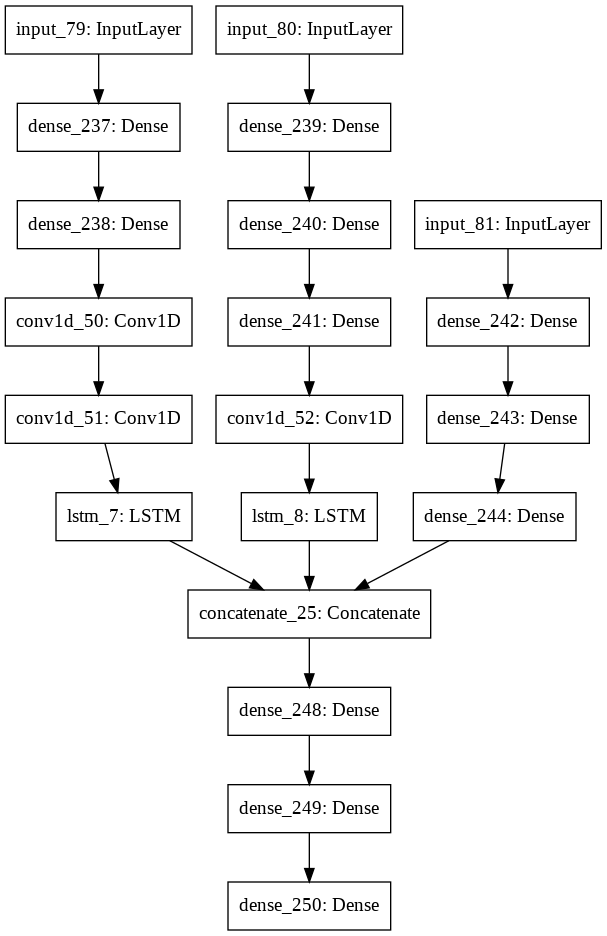

In [329]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, MaxPool1D
from keras.layers.merge import concatenate

# first input model
visible1 = keras.layers.Input(shape=(12, 1290))
x1 = keras.layers.Dense(30, activation="tanh")(visible1)
x1 = keras.layers.Dense(256, activation="elu")(x1)
x1 = keras.layers.Conv1D(32, 3, activation="tanh")(x1)
x1 = keras.layers.Conv1D(16, 3, activation="tanh")(x1)
# x1 = keras.layers.Flatten()(x1)
x1 = keras.layers.LSTM(units=64)(x1)

visible2 = keras.layers.Input(shape=(20, 1290))
x2 = keras.layers.Dense(30, activation="elu")(visible2)
x2 = keras.layers.Dense(256, activation="elu")(x2)
x2 = keras.layers.Dense(32, activation="elu")(x2)
x2 = keras.layers.Conv1D(32, 3, activation="tanh")(x2)
x2 = keras.layers.LSTM(units=64)(x2)
# x2 = keras.layers.MaxPool1D()(x2)
# x2 = keras.layers.Flatten()(x2)

visible3 = keras.layers.Input(shape=(5, ))
x3 = keras.layers.Dense(30, activation="tanh")(visible3)
x3 = keras.layers.Dense(256, activation="tanh")(x3)
x3 = keras.layers.Dense(32, activation="tanh")(x3)

print("x3: {}".format(x3.shape))

merge = keras.layers.merge.concatenate([x1, x2, x3])
# merge = keras.layers.merge.concatenate([x1])

print(x1)
print(x2)
print(merge)

output = keras.layers.Dense(256, activation="relu")(merge)
output = keras.layers.Dense(1024, activation="tanh")(merge)
output = keras.layers.Dense(512, activation="tanh")(merge)
output = keras.layers.Dense(1024, activation="tanh")(merge)
output = keras.layers.Dense(32, activation="relu")(output)
output = keras.layers.Dense(10, activation="softmax")(output)

print(output)

model = Model(inputs=[visible1, visible2, visible3], outputs=output)


print(model.summary())
# plot graph
plot_model(model, to_file='multiple_inputs.png')



In [330]:
model.compile(optimizer="Adadelta", loss="mse", metrics=["accuracy"])

# Готовим данные

In [337]:
# Обогащаем данные
x_train1 = np.array(get_multi_batch(x_train1, 100, 10)).reshape(-1, 5)
x_train2 = np.array(get_multi_batch(x_train2, 100, 10)).reshape(-1, 12, 1290)
x_train3 = np.array(get_multi_batch(x_train3, 100, 10)).reshape(-1, 20, 1290)
y_train = np.array(get_multi_batch(y_train, 100, 10)).reshape(-1, 10)


print(x_train1.shape)
print(x_train2.shape)
print(x_train3.shape)
print(y_train.shape)

(9100, 5)
(9100, 12, 1290)
(9100, 20, 1290)
(9100, 10)


In [338]:
# Делим на тестовую и проверочную выборки
from sklearn.model_selection import train_test_split
x_train1, x_test1, x_train2, x_test2, x_train3, x_test3, y_train, y_test = train_test_split(x_train1, x_train2, x_train3, y_train, test_size=0.2)

In [339]:
# Проверяем размерность
print(x_train1.shape)
print(x_train2.shape)
print(x_train3.shape)
print(y_train.shape)

(7280, 5)
(7280, 12, 1290)
(7280, 20, 1290)
(7280, 10)


# Обучение сети

In [340]:
history = model.fit([x_train2, x_train3, x_train1], y_train, 
                    batch_size=128, 
                    epochs=300, 
                    validation_data=([x_test2, x_test3, x_test1], y_test),
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)])



Train on 7280 samples, validate on 1820 samples
Epoch 1/300
7280/7280 [==============================] - 10s 1ms/step - loss: 0.0875 - accuracy: 0.1963 - val_loss: 0.0847 - val_accuracy: 0.2225
Epoch 2/300
7280/7280 [==============================] - 8s 1ms/step - loss: 0.0813 - accuracy: 0.3257 - val_loss: 0.0772 - val_accuracy: 0.3918
Epoch 3/300
7280/7280 [==============================] - 8s 1ms/step - loss: 0.0749 - accuracy: 0.4016 - val_loss: 0.0714 - val_accuracy: 0.4407
Epoch 4/300
7280/7280 [==============================] - 8s 1ms/step - loss: 0.0694 - accuracy: 0.4690 - val_loss: 0.0682 - val_accuracy: 0.4582
Epoch 5/300
7280/7280 [==============================] - 9s 1ms/step - loss: 0.0632 - accuracy: 0.5299 - val_loss: 0.0587 - val_accuracy: 0.5720
Epoch 6/300
7280/7280 [==============================] - 8s 1ms/step - loss: 0.0533 - accuracy: 0.6187 - val_loss: 0.0474 - val_accuracy: 0.6786
Epoch 7/300
7280/7280 [==============================] - 9s 1ms/step - loss: 0.04

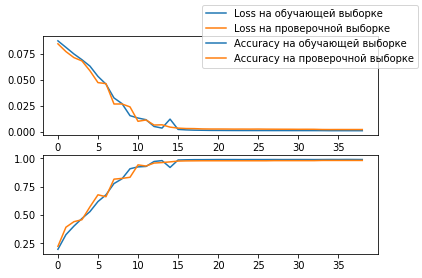

In [341]:
# Визуализируем обучение
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history["loss"], label="Loss на обучающей выборке")
ax[0].plot(history.history["val_loss"], label="Loss на проверочной выборке")
ax[1].plot(history.history["accuracy"], label="Accuracy на обучающей выборке")
ax[1].plot(history.history["val_accuracy"], label="Accuracy на проверочной выборке")
fig.legend()
plt.show()

# Проверяем предсказание сети

In [342]:
y, sr = librosa.load("/content/genres/metal/metal.00007.au", mono=True, duration=50)
x1, x2, x3 = get_features(y, sr)

x1 = np.array(x1).reshape(-1, 5)
x2 = np.array(x2).reshape(-1, 12, 1290)
x3 = np.array(x3).reshape(-1, 20, 1290)
# x_train2 = np.array(x_train2).reshape(1000, 12, -1)
# x_train3 = np.array(x_train3).reshape(1000, 20, -1)

print(x1.shape)
print(x2.shape)
print(x3.shape)


(1, 5)
(1, 12, 1290)
(1, 20, 1290)


In [343]:
# Получаем предсказание сети по файлу
val = model.predict([x2, x3, x1])

In [344]:
val

array([[8.2208298e-06, 6.4949091e-07, 8.9824331e-05, 3.7927655e-04,
        2.2444169e-06, 2.6499645e-08, 9.9770808e-01, 6.4538923e-11,
        9.6015573e-10, 1.8116424e-03]], dtype=float32)

In [345]:
# Получаем жанр и убеждаемся, что сеть права, это метал
res = np.argmax(val)
print(genres[res])

metal


In [346]:
# Попробуем еще
y, sr = librosa.load("/content/genres/disco/disco.00017.au", mono=True, duration=50)
x1, x2, x3 = get_features(y, sr)

x1 = np.array(x1).reshape(-1, 5)
x2 = np.array(x2).reshape(-1, 12, 1290)
x3 = np.array(x3).reshape(-1, 20, 1290)
val = model.predict([x2, x3, x1])
res = np.argmax(val)
print(genres[res])


disco


Сеть опять права, это диско )